##![LearnAI Header](https://coursematerial.blob.core.windows.net/assets/LearnAI_header.png)

# Classification using Automated ML

In this example we use Azure ML's Automated ML functionality to improve on the classifier we built earlier. Automated ML handles the task of building many models from a wide variety of algorithms and choosing a good set of hyper-parameters for them. We then select best the model (or one that meets our criteria) and deploy it as a web service.

## Load and prepare experiment

As part of the setup we have already created an AML workspace. Let's load the workspace and create an experiment.

In [5]:
import json
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn import datasets

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

We load the workspace directly from the config file we created in the early part of the course.

In [7]:
config_path = '/dbfs/tmp/aml_config'
ws = Workspace.from_config(path=os.path.join(config_path, 'config.json'))

experiment_name =  'pred-maint-automl' # choose a name for experiment
project_folder = '.' # project folder

experiment=Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

Found the config file in: /dbfs/tmp/aml_config/config.json
 Out[ 2 ]: 
 
Experiment Name pred-maint-automl 
Location westus2 
Project Directory . 
Resource Group adb_airlift_rg 
SDK version 1.0.17 
Subscription ID 5be49961-ea44-42ec-8021-b728be90d58c
Workspace myADBworkspace

Opt in for diagnostics for better experience, quality, and security of future releases:

In [9]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics=True)

Turning diagnostics collection on.

## Instantiate config file

We now instantiate a `AutoMLConfig` object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize.<br> Classification supports the following primary metrics <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>balanced_accuracy</i><br><i>average_precision_score_weighted</i><br><i>precision_score_weighted</i>|
|**max_time_sec**|Time limit in seconds for each iterations|
|**iterations**|Number of iterations. In each iteration Auto ML trains the data with a specific pipeline|
|**n_cross_validations**|Number of cross validation splits|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification.  This should be an array of integers. |
|**path**|Relative path to the project folder.  AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder. |

In [12]:
df = spark.read.parquet("dbfs:/FileStore/tables/preprocessed").cache()
display(df)

machineID,datetime,age,diff_error_0,diff_error_1,diff_error_2,diff_error_3,diff_error_4,diff_fail_0,diff_fail_1,diff_fail_2,diff_fail_3,diff_maint_0,diff_maint_1,diff_maint_2,diff_maint_3,pressure_ma_3,pressure_sd_3,rotate_ma_3,rotate_sd_3,vibration_ma_3,vibration_sd_3,volt_ma_3,volt_sd_3,y_0,y_1,y_2,y_3
16,2015-06-10T23:00:00.000+0000,3,489.0,318.0,257.0,617.0,2142.0,1673.0,233.0,593.0,3957.0,953.0,233.0,593.0,1313.0,103.36172205524505,7.328405874766052,470.40251318654725,92.20329334384515,36.4696066569045,3.3063509142485454,162.77538146117274,17.15059004541141,0,0,0,0
16,2015-06-11T00:00:00.000+0000,3,490.0,319.0,258.0,618.0,2143.0,1674.0,234.0,594.0,3958.0,954.0,234.0,594.0,1314.0,99.363131214606,10.871060485258129,446.91811499211394,82.57552287693811,38.15925421485703,5.68406531953323,170.811166158514,1.9468855435949943,0,0,0,0
16,2015-06-11T01:00:00.000+0000,3,491.0,320.0,259.0,619.0,2144.0,1675.0,235.0,595.0,3959.0,955.0,235.0,595.0,1315.0,101.39131534989146,10.023193445589618,440.04974209269324,78.79381696420629,41.111666609672355,4.009084955041661,172.64899000407274,5.118941409799331,0,0,0,0
16,2015-06-11T02:00:00.000+0000,3,492.0,321.0,260.0,620.0,2145.0,1676.0,236.0,596.0,3960.0,956.0,236.0,596.0,1316.0,98.36866553478745,8.587414855405909,472.6304420269753,36.17558170016903,40.805403622712525,4.297997479151865,168.56396337307723,11.543020480874953,0,0,0,0
16,2015-06-11T03:00:00.000+0000,3,493.0,322.0,261.0,621.0,2146.0,1677.0,237.0,597.0,3961.0,957.0,237.0,597.0,1317.0,94.53421765518715,5.968726222941755,460.0051519863225,14.962694219838605,40.318859899470176,4.948653154935858,165.95955799828124,11.578897552357208,0,0,0,0
16,2015-06-11T04:00:00.000+0000,3,494.0,323.0,262.0,622.0,2147.0,1678.0,238.0,598.0,3962.0,958.0,238.0,598.0,1318.0,95.50008347465094,4.557688829884692,463.05209361891275,9.315773330681766,40.23520369738577,4.834785987328766,169.3007077087945,14.443743556629142,0,0,0,0
16,2015-06-11T05:00:00.000+0000,3,495.0,324.0,263.0,623.0,2148.0,1679.0,239.0,599.0,3963.0,959.0,239.0,599.0,1319.0,93.33858647635662,2.6168933071748706,469.417713108793,15.782893006930236,39.08330534417315,4.326818066247427,165.246881515914,12.606379112554771,0,0,0,0
16,2015-06-11T06:00:00.000+0000,3,496.0,325.0,264.0,624.0,2149.0,1680.0,240.0,600.0,3964.0,960.0,240.0,600.0,1320.0,93.63201011705628,3.189767394885411,477.4132658130537,20.319239222031907,40.208246848146146,4.330782174852976,172.3030821213965,10.968488570133442,0,0,0,0
16,2015-06-11T07:00:00.000+0000,3,497.0,326.0,265.0,625.0,2150.0,1681.0,241.0,601.0,3965.0,961.0,241.0,601.0,1321.0,96.48519840591158,5.848380359115432,472.9917483316395,23.23167780183143,41.5679305797079,2.66313041318923,176.98691452605274,8.8624264766146,0,0,0,0
16,2015-06-11T08:00:00.000+0000,3,498.0,327.0,266.0,626.0,2151.0,1682.0,242.0,602.0,3966.0,962.0,242.0,602.0,1322.0,100.6964862682261,6.751963714111103,474.76970430137476,21.139977606679178,39.69481984381637,1.8619248647472575,174.94751064292976,8.013683276232097,0,0,0,0


In [13]:
from pandas import datetime
from pyspark.sql.functions import col, hour

# we sample every nth row of the data using the `hour` function
df_train = df.filter((col('datetime') < datetime(2015, 10, 1))) # & (hour(col('datetime')) % 3 == 0))
df_test = df.filter(col('datetime') > datetime(2015, 10, 15))

In [14]:
X_keep = ['diff_maint_1', 'diff_error_1', 'volt_sd_3', 'diff_fail_3', 'pressure_ma_3', 'pressure_sd_3', 'diff_fail_1', 'diff_fail_0', 'age', 'vibration_ma_3', 'rotate_ma_3', 'diff_error_2', 'diff_fail_2', 'diff_error_3', 'diff_maint_2', 'volt_ma_3', 'diff_maint_0', 'vibration_sd_3', 'diff_maint_3', 'rotate_sd_3', 'diff_error_0', 'diff_error_4']
Y_keep = ['y_0', 'y_1', 'y_2', 'y_3']

# for now, we convert the spark DataFrames to Pandas dataframes, 
# because at this point automated ML only supports the latter. 
# This will change soon though.
X_train = df_train.select(X_keep).toPandas() 
X_test = df_test.select(X_keep).toPandas() 
y_train = df_train.select(Y_keep).toPandas() 
y_test = df_test.select(Y_keep).toPandas() 

In [15]:
X_train.head()

Out[ 13 ]: 
 diff_maint_1 diff_error_1 ... diff_error_0 diff_error_4
0 233.00 318.00 ... 489.00 2142.00 
1 234.00 319.00 ... 490.00 2143.00 
2 235.00 320.00 ... 491.00 2144.00 
3 236.00 321.00 ... 492.00 2145.00 
4 237.00 322.00 ... 493.00 2146.00 

[5 rows x 22 columns]

In [16]:
X_train.columns

Out[ 14 ]: 
Index(['diff_maint_1', 'diff_error_1', 'volt_sd_3', 'diff_fail_3',
 'pressure_ma_3', 'pressure_sd_3', 'diff_fail_1', 'diff_fail_0', 'age',
 'vibration_ma_3', 'rotate_ma_3', 'diff_error_2', 'diff_fail_2',
 'diff_error_3', 'diff_maint_2', 'volt_ma_3', 'diff_maint_0',
 'vibration_sd_3', 'diff_maint_3', 'rotate_sd_3', 'diff_error_0',
 'diff_error_4'],
 dtype='object')

In [17]:
y_train.head()

Out[ 15 ]: 
 y_0 y_1 y_2 y_3
0 0 0 0 0 
1 0 0 0 0 
2 0 0 0 0 
3 0 0 0 0 
4 0 0 0 0

Here are the metrics we can choose to optimize our model over.

In [19]:
azureml.train.automl.constants.Metric.CLASSIFICATION_PRIMARY_SET

Out[ 16 ]: 
{'AUC_weighted',
 'accuracy',
 'average_precision_score_weighted',
 'norm_macro_recall',
 'precision_score_weighted'}

We now set up a configuration file for the automated ML training experiment. It contains details for how the experiment should run.

In [21]:
automl_config = AutoMLConfig(task='classification', 
                             preprocess=False,
                             name=experiment_name,
                             debug_log='automl_errors.log',
                             primary_metric='AUC_weighted',
                             iteration_timeout_minutes=5,
                             iterations=3,
                             verbosity=logging.INFO,
                             X = X_train.values, # we convert from pandas to numpy arrays using .vaules
                             y = y_train.values[:, 0], # we convert from pandas to numpy arrays using .vaules
                             X_valid=X_test.values,
                             y_valid=y_test.values[:, 0],
                             path=project_folder)

## Run training experiment

You can call the submit method on the experiment object and pass the run configuration. For Local runs the execution is synchronous. Depending on the data and number of iterations this can run for while.
You will see the currently running iterations printing to the console.

In [24]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_1a836dd7-b5ef-4ea9-915a-e9cdc0027a5c
********************************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
SAMPLING %: Percent of the training data to sample.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
********************************************************************************************************************

 ITERATION PIPELINE SAMPLING % DURATION METRIC BEST
 0 StandardScalerWrapper LightGBM 100.0000 0:00:17 0.9544 0.9544
 1 StandardScalerWrapper LightGBM 100.0000 0:00:20 0.9703 0.9703
 2 Ensemble 100.0000 0:00:16 0.9703 0.9703

#### Portal URL for Monitoring Runs

The following will provide a link to the web interface to explore individual run details and status.

In [26]:
displayHTML("<a href={} target='_blank'>Your experiment in Azure Portal: {}</a>".format(local_run.get_portal_url(), local_run.id))

Your experiment in Azure Portal: AutoML_1a836dd7-b5ef-4ea9-915a-e9cdc0027a5c

## Retrieve the Best Model

Below we select the best pipeline from our iterations. The *get_output* method on automl_classifier returns the best run and the fitted model for the last *fit* invocation. There are overloads on *get_output* that allow you to retrieve the best run and fitted model for *any* logged metric or a particular *iteration*.

In [28]:
best_run, fitted_model = local_run.get_output()

In [29]:
fitted_model

Out[ 21 ]: 
Pipeline(memory=None,
 steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
 estimators=[('LightGBM', Pipeline(memory=None,
 steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f474f8b5940>), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7f47502c5c50>)]))],
 flatten_transform=None, weights=[1.0]))])

We can see from the above results that `StandardScalerWrapper` was used to scale the features and a `LightGBMClassifier` was chosen as the best model based on the metric we defined. This of course does NOT automatically also make it the best model in production, but choosing the right model for production is beyond the scope of this course so we will not address it here.

### Hands-on lab

Run the following cell and go to the link provided under Details Page. This links will take us to the Azure portal. Examine the content of the page. Can you find what resource group this resource is under? What kind of resource is it?

In [33]:
displayHTML("<a href={} target='_blank'>Your experiment in Azure Portal: {}</a>".format(best_run.get_portal_url(), best_run.id))

Your experiment in Azure Portal: AutoML_1a836dd7-b5ef-4ea9-915a-e9cdc0027a5c_2

In addition to choosing a good algorithm, the experiment also tuned hyper-parameters. So our model didn't just run with the default hyper-parameter values. Find out how we can get the chosen hyper-parameters from the `fitted_model` object. Describe the hyper-parameters you see. Which ones do you think are the most critical ones?

In [35]:
# write solution here

### End of lab

We can run the following code to get the hyper-parameters for the chosen model.

In [38]:
n_steps = len(fitted_model.steps)

for s in range(n_steps):
  print("Step: %s" % s)
  params = fitted_model.steps[s][1].get_params()
  print(params)


Step: 0
{'LightGBM__LightGBMClassifier__learning_rate': 0.03158578947368421, 'estimators': [('LightGBM', Pipeline(memory=None,
 steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f474f8b5940>), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7f47502c5c50>)]))], 'LightGBM__StandardScalerWrapper': <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f474f8b5940>, 'weights': [1.0], 'LightGBM__LightGBMClassifier__random_state': None, 'LightGBM__StandardScalerWrapper__copy': True, 'LightGBM__LightGBMClassifier__n_jobs': 1, 'LightGBM__LightGBMClassifier__verbose': -10, 'LightGBM__LightGBMClassifier__objective': None, 'LightGBM__LightGBMClassifier__subsample': 0.6931578947368422, 'LightGBM__memory': None, 'LightGBM__StandardScalerWrapper__cls': <class 'sklearn.preprocessing.data.StandardScaler'>, 'LightGBM__LightGBMClassifier__reg_lambda': 1, 'classification_labels': None, 'LightGBM__LightGBMClassifier__reg_alpha': 0.7894736842105263, 'LightGBM__LightGBMClassifier': <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7f47502c5c50>, 'LightGBM__LightGBMClassifier__max_bin': 70, 'LightGBM__steps': [('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f474f8b5940>), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7f47502c5c50>)], 'LightGBM__LightGBMClassifier__importance_type': 'split', 'LightGBM__LightGBMClassifier__min_child_samples': 13549, 'flatten_transform': None, 'LightGBM__LightGBMClassifier__min_child_weight': 8, 'LightGBM__StandardScalerWrapper__with_mean': True, 'LightGBM__LightGBMClassifier__min_split_gain': 0.5263157894736842, 'LightGBM__LightGBMClassifier__subsample_freq': 0, 'LightGBM': Pipeline(memory=None,
 steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f474f8b5940>), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7f47502c5c50>)]), 'LightGBM__LightGBMClassifier__colsample_bytree': 0.2977777777777778, 'LightGBM__LightGBMClassifier__boosting_type': 'gbdt', 'LightGBM__LightGBMClassifier__silent': True, 'LightGBM__LightGBMClassifier__max_depth': 7, 'LightGBM__LightGBMClassifier__class_weight': None, 'LightGBM__LightGBMClassifier__n_estimators': 100, 'LightGBM__LightGBMClassifier__num_leaves': 98, 'LightGBM__LightGBMClassifier__subsample_for_bin': 200000, 'LightGBM__StandardScalerWrapper__with_std': True}

## Score and evaluate the chosen model

Let's now pick the best model returned by the experiment and use it to get predictions for the test data. This is simply done by replacing `manual_model.predict` with `fitted_model.predict`.

In [41]:
y_pred = fitted_model.predict(X_test)

We should get the same confusion matrix we did in the section above.

In [43]:
confusion_matrix(y_test.values[:, 0], y_pred)

Out[ 25 ]: 
array([[185699, 13],
 [ 1641, 447]])

We use `classification_report` to automatically calculate precision, recall, and the F-1 score from the confusion matrix above.

In [45]:
cl_report = classification_report(y_test.values[:, 0], y_pred)
print(cl_report)

precision recall f1-score support

 0 0.99 1.00 1.00 185712
 1 0.97 0.21 0.35 2088

avg / total 0.99 0.99 0.99 187800

The AUC is just the area under the ROC curve shown here:

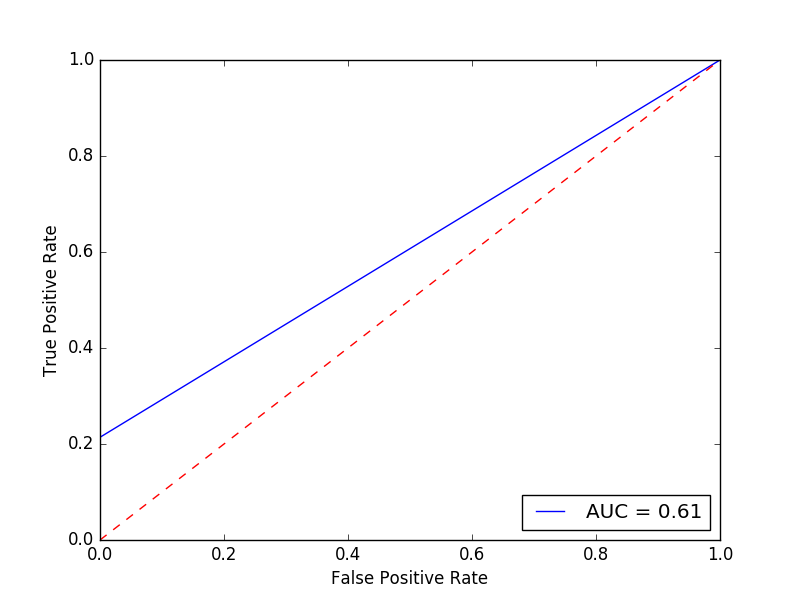

In [47]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, thresholds = roc_curve(y_test.values[:, 0], y_pred)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'b', label = 'AUC = {0:.2f}'.format(roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
display()

## Register fitted model for deployment

Now that we have a model we're happy with, we register it to our Azure ML account. This will be the first step toward model management and deployment, which we cover in the next Notebook. Registered models can also be loaded into other workspaces.

In [50]:
description = 'automated ML PdM (predict y_1)'
tags = None
model = local_run.register_model(description=description, tags=tags)
local_run.model_id # Use this id to deploy the model as a web service in Azur

Registering model AutoML1a836dd7bbest
 Out[ 28 ]: 'AutoML1a836dd7bbest'

Optionally, we can also take the model and save it on disk as a pickle file, as shown here:

In [52]:
from sklearn.externals import joblib
joblib.dump(value=fitted_model, filename='model.pkl')

Out[ 29 ]: ['model.pkl']

### Hands-on lab

<div class="alert alert-info">
So far we used automated ML to automatically train a classification model for only one of the four failure types, namely `y_1`. Write a loop to use automated ML to train, score and evaluate and finally register a classification model for `y_2`, `y_3` and `y_4`. In each case, compare the evaluation metrics we obtain to the ones we obtained in the previous Notebook when we hand-trained a model.
</div>

In [55]:
all_output = {'y_1': {'local_run': local_run, 'model': model, 'cl_report': cl_report}}

for i in range(1, 4): ## loop over each target class
    print("Running automl on y_" + str(i+1))
    ## YOUR CODE GOES HERE (modify the config file to point to the right target class)
    ## YOUR CODE GOES HERE (submit the automated ML experiment)
    ## YOUR CODE GOES HERE (extract the best model)
    ## YOUR CODE GOES HERE (predict on the test data)
    ## YOUR CODE GOES HERE (find the classification report for the best model and add it to y_report)
    ## YOUR CODE GOES HERE (add results to all_output)
    ## YOUR CODE GOES HERE (register the final model)

Running automl on y_2
Running automl on y_3
Running automl on y_4

Here's the solution:

In [57]:
all_output = {'y_1': {'local_run': local_run, 'model': model, 'cl_report': cl_report}}

for i in range(1, 4): ## loop over each target class
    print("Running automl on y_" + str(i+1))
    automl_config.fit_params.update({'y': y_train.values[:, i]})
    local_run = experiment.submit(automl_config, show_output=True)
    best_run, fitted_model = local_run.get_output()
    y_pred = fitted_model.predict(X_test)
    cl_report = classification_report(y_test.values[:, i], y_pred)
    print(cl_report)
    all_output['y_' + str(i+1)] = {'local_run': local_run, 'cl_report': cl_report}
    description = 'autometed ML PdM (predict y_{})'.format(str(i+1))
    model = local_run.register_model(description=description, tags=None)

<div class="alert alert-info">
NOTE: We can use automated ML to directly train a multi-class classification model instead of training many binary classification models. We will explore that in another Notebook.
</div>

### End of lab

In [60]:
# You can ignore this code, we use it for testing our notebooks.
assert isinstance(model, azureml.core.model.Model)

# The end

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.